# Braille detection with CNN
### Justine Diliberto, Anna Nikiforovskaja, Cindy Pereira

In this script we create, train and evaluate image classifiers based on convolutional networks to recognize Braille characters. \
The first model is nicknamed "simple", the second "6 cells", and the last "6 cells + map". They are described in their corresponding parts.


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from torch.utils.data import Dataset, DataLoader
import fnmatch
from skimage import io, transform
import torchvision
import pandas as pd

# Define the device and data repository
device = 'cpu'
data_dir = 'dataset/'

# Data management

We read data, split it onto train, validation and test sets. We also create data loaders along with preprocessing.

In [4]:
# We start by creating a class object for representing our image data
# This is a subclass of torch.utils.data.dataset.Dataset that will serve as input to the DataLoader

class ImageDataset(Dataset):

    def __init__(self, image_dir, transform=None):
        """Initialize the attributes of the object of the class."""
        self.image_dir = image_dir
        self.image_files = sorted(self._find_files(image_dir))
        # Get the first character in each filename: corresponds to the letter of the file
        # ex: dataset/a1.JPG0dim.jpg -> get the "a"
        self.classes = [filename.split("/")[-1][0] for filename in self.image_files]
        # Create a dictionary associating a number to each letter
        self.let2num = {a: i for i, a in enumerate(sorted(list(set(self.classes))))}
        # Create the reverted dictionary with number as key
        self.num2let = {i: a for a, i in self.let2num.items()}
        self.transform = transform
        
    def letter_to_number(self, let):
        """Get the number associated to a letter"""
        return self.let2num[let]
    
    def number_to_letter(self, num):
        """Get the letter associated to a number"""
        return self.num2let[num]
    

    def __len__(self):
        """Get the size of the dataset."""
        return len(self.image_files)

    def __getitem__(self, index):
        """Here we return a data sample for a given index."""
        filename = self.image_files[index]
        x = io.imread(filename)
        
        if self.transform:
            x = self.transform(x)
        return x, self.classes[index]

    def _find_files(self, directory, pattern='*.jpg'):
        """Recursively finds all files matching the pattern."""
        files = []
        for root, dirnames, filenames in os.walk(directory):
            for filename in fnmatch.filter(filenames, pattern):
                files.append(os.path.join(root, filename))
        return files


In [5]:
# Create the transform to apply on the data
data_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize(
                                                      mean=(0.5, 0.5, 0.5), 
                                                      std=(0.3,0.3,0.3))])

In [6]:
# Create the dataset
dataset = ImageDataset(image_dir=data_dir, transform=data_transforms)

Here we check that our Dataset class and functions work fine.

In [7]:
len(set(dataset.classes))

26

We have 26 classes, which is as planned (they correspond to each letter of the alphabet)

We can now look at a sample of the dataset:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


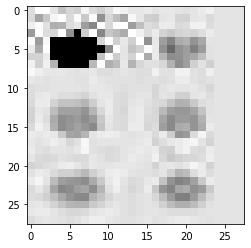

In [8]:
plt.imshow(dataset[0][0].numpy().transpose(1, 2, 0))

In [9]:
# Check the size of the first element
dataset[0][0].size()

torch.Size([3, 28, 28])

We check that the first element of letter_to_number corresponds to the first element of number_to_letter:
(meaning the mapping is correct, for example "a" is the 0th element)

In [10]:
dataset.letter_to_number(dataset[0][1])

0

In [11]:
dataset.number_to_letter(0)

'a'

In [12]:
# Get the lengths of train (80%), validation (10%) and test (10%) sets
dataset_ln = len(dataset)
train_ln, val_ln, test_ln = int(dataset_ln * 0.8), int(dataset_ln * 0.1), int(dataset_ln * 0.1)

In [13]:
# Split the data into train, validation and test sets
train_data, val_data, test_data = torch.utils.data.random_split(dataset, [train_ln, val_ln, test_ln], generator=torch.Generator().manual_seed(42))

In [14]:
len(val_data)

156

In [15]:
val_data[1]

(tensor([[[1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          [1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          [1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          ...,
          [1.6536, 1.6536, 1.6536,  ..., 1.6405, 1.6405, 1.6536],
          [1.6536, 1.6536, 1.6536,  ..., 1.6405, 1.6405, 1.6536],
          [1.6536, 1.6536, 1.6536,  ..., 1.6405, 1.6405, 1.6536]],
 
         [[1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          [1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          [1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          ...,
          [1.6536, 1.6536, 1.6536,  ..., 1.6405, 1.6405, 1.6536],
          [1.6536, 1.6536, 1.6536,  ..., 1.6405, 1.6405, 1.6536],
          [1.6536, 1.6536, 1.6536,  ..., 1.6405, 1.6405, 1.6536]],
 
         [[1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          [1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          [1.6667, 1.6667, 1.6536,  ...,

In [16]:
def collate_fn(data):
    """Associate images with labels"""
    images, labels = zip(*data)
    # Get the number corresponding to each label
    labels = [dataset.letter_to_number(label) for label in labels]
    return torch.stack(images).float(), torch.tensor(labels).long()


In [17]:
# Load data using a batch size of 8
batch_size = 8
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size, collate_fn=collate_fn)
val_dataloader = DataLoader(val_data, batch_size=batch_size, collate_fn=collate_fn)
test_dataloader = DataLoader(test_data, batch_size=batch_size, collate_fn=collate_fn)

# Useful functions for training, validation and testing

This part contains functions that are used in our different models. They are useful to train, validate and test the models.

In [18]:
def train_model(model, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate, 
                device='cpu', verbose=True, model_name='simple', optim='SGD', cells=False):
    """Train the model"""

    # Copy the model to the device and set it in 'training' mode (thus all gradients are computed)
    model = model.to(device)
    model.train()
    
    # Define the optimizer
    if optim == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    elif optim == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Initialize a list to record the training loss over epochs
    loss_all_epochs = []
    
    last_best_acc = 0
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0
        
        # Iterate over batches using the dataloader
        for batch_index, (images, labels) in enumerate(train_dataloader):
            #print(labels)
            #print(images.size(), labels.size(), labels)
            images = images.to(device)
            # cells is True if we use the 3rd model
            if cells:
                # In this case, labels are bits where 1 corresponds to a black dot in Braille
                new_labels = torch.zeros((len(labels), 6))
                for i, l in enumerate(labels):
                    new_labels[i] = torch.tensor(list(map(int, braille_map[dataset.number_to_letter(l.item())]))).float()
                labels = new_labels
            else:
                labels = labels.to(device)
            # Predict ys
            y_pred = model(images)
            # Apply loss function on predictions
            loss = loss_fn(y_pred, labels)
            
            # Compute the gradient
            loss.backward()
            # Update the parameters
            optimizer.step()
            # Set the gradients to 0
            optimizer.zero_grad()
            # Update the loss
            loss_current_epoch += loss.item()
        
        # Compute the accuracy
        cur_acc = eval_model(model, valid_dataloader)
        # Save the parameters if it's the new best accuracy 
        if cur_acc > last_best_acc:
            last_best_acc = cur_acc
            torch.save(model.state_dict(), f'models/model_{model_name}_best.pt')
            print("\nNew best accuracy! ", last_best_acc)
            
        # At the end of each epoch, record and display the loss over all batches
        loss_all_epochs.append(loss_current_epoch)
        if verbose:
            print('\rEpoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch), end='')
        
    return model, loss_all_epochs

In [19]:
def eval_model(model, eval_dataloader, device='cpu'):
    """Evaluate the model"""
    
    # Copy the model to the device
    model.to(device)
    # Set the model in 'evaluation' mode (this disables some layers (batch norm, dropout...) which are not needed when testing)
    model.eval() 

    # In evaluation phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # Initialize the total and correct number of labels to compute the accuracy
        correct_labels = 0
        total_labels = 0
        
        # Iterate over the dataset using the dataloader
        for images, labels in eval_dataloader:

            # Get the predicted labels classes
            images = images.to(device)
            labels = labels.to(device)
            y_predicted = model(images)
            
            # To get the predicted labels, we need to get the max over all possible classes
            _, label_predicted = torch.max(y_predicted.data, 1)
            
            # Compute accuracy: count the total number of samples, and the correct labels (compare the true and predicted labels)
            total_labels += labels.size(0)
            correct_labels += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct_labels / total_labels
    
    return accuracy

In [20]:
# Create a dataframe to store the results
all_results = {"Model":[], "Loss":[], "Optimizer":[], "lr":[], "Accuracy":[]}

# First model

Our first model is a simple CNN classifier, with 2 sequential layers each containing convolution, rectified linear unit, batch normalization and max pooling.

In [21]:
# Define a CNN classifier module.

class CNNSimpleClassif(nn.Module):
    def __init__(self, num_channels1=16, num_channels2=32, num_classes=26):
        """Models a simple classifier"""
        super(CNNSimpleClassif, self).__init__()
        
        # Create two sequential layers with convolution, ReLU, BatchNorm and Max Pooling
        self.l1 = nn.Sequential(nn.Conv2d(3, num_channels1, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(16),
                           nn.MaxPool2d(kernel_size=2))
        self.l2 = nn.Sequential(nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(32),
                           nn.MaxPool2d(kernel_size=2))
        
        size_vec = 1568
        # Create a linear layer
        self.res = nn.Linear(size_vec, num_classes)
        

    def forward(self, x):
        """Move from the input layers to the output layer"""
        x = self.l2(self.l1(x))
        x = x.reshape(x.shape[0], -1)
        out = self.res(x)
        return out

## Experiments

After having set up the model, we set the parameters to run on, create the instance, and train it.

In [22]:
# Set the parameters
num_channels1 = 16
num_channels2 = 32
num_classes = 26
# Create the model following the simple classifier
model = CNNSimpleClassif(num_channels1, num_channels2, num_classes)


New best accuracy!  35.256410256410255
Epoch [1/20], Loss: 421.9903
New best accuracy!  57.69230769230769
Epoch [2/20], Loss: 268.9563
New best accuracy!  58.97435897435897
Epoch [3/20], Loss: 210.6603
New best accuracy!  62.17948717948718
Epoch [4/20], Loss: 176.4887
New best accuracy!  64.1025641025641
Epoch [5/20], Loss: 152.8673
New best accuracy!  65.38461538461539
Epoch [6/20], Loss: 133.2837
New best accuracy!  67.94871794871794
Epoch [7/20], Loss: 119.0353
New best accuracy!  71.7948717948718
Epoch [9/20], Loss: 92.43165
New best accuracy!  73.71794871794872
Epoch [12/20], Loss: 63.8500
New best accuracy!  75.64102564102564
Epoch [16/20], Loss: 38.3672
New best accuracy!  76.28205128205128
Epoch [17/20], Loss: 34.2119
New best accuracy!  76.92307692307692
Epoch [18/20], Loss: 31.0201
New best accuracy!  77.56410256410257
Epoch [20/20], Loss: 24.4939

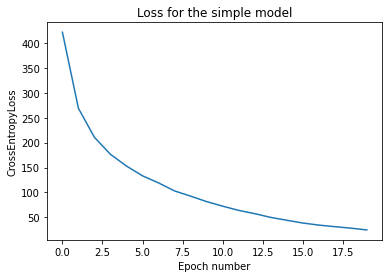

In [23]:
# Optimizer
num_epochs = 20
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.001

# Training
model, loss_total = train_model(model, train_dataloader, val_dataloader, num_epochs, loss_fn, learning_rate, device='cpu', verbose=True)

# Save the model and display the loss over epochs
torch.save(model.state_dict(), 'models/model_simple.pt')
plt.plot(loss_total)

# Plot the results and save the figure
plt.title("Loss for the simple model")
plt.xlabel("Epoch number")
plt.ylabel("CrossEntropyLoss")
plt.savefig("plots/model_simple_loss.png")
plt.show() 

In [24]:
# Reloading the model using simple classifier
model = CNNSimpleClassif(num_channels1, num_channels2, num_classes)
# Load the model
model.load_state_dict(torch.load('models/model_simple_best.pt'))
# Compute the accuracy
res = eval_model(model, test_dataloader, device='cpu')
print(res)

79.48717948717949


As we can observe, the results are satisfying, with an accuracy around 83% (there are slight changes at each test).

In [25]:
# Fill dataframe with the results of this model
all_results["Model"].append("simple")
all_results["Loss"].append("CrossEntropyLoss")
all_results["Optimizer"].append("SGD")
all_results["lr"].append(learning_rate)
all_results["Accuracy"].append(res)

# Second model

Our second model uses the fact that Braille characters are composed of 6 dots, it will thus focus on identifying the black dots. It is also a CNN classifier.

In [26]:
# Define a CNN classifier module.

class CNNSimple6Cells(nn.Module):
    def __init__(self, num_channels1=16, num_channels2=32, num_classes=26):
        """Models a classifier using the 6 dots"""
        super(CNNSimple6Cells, self).__init__()
        
        # Create two sequential layers with convolution, ReLU, BatchNorm and Max Pooling
        self.l1 = nn.Sequential(nn.Conv2d(3, num_channels1, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(16),
                           nn.MaxPool2d(kernel_size=2))
        self.l2 = nn.Sequential(nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(32),
                           nn.MaxPool2d(kernel_size=2))
        
        size_vec = 1568
        # Create a sequential layer with linear and ReLU 
        self.lin6 = nn.Sequential(nn.Linear(size_vec, 6), nn.ReLU())
        # Create a sequential layer with linear, ReLU and another linear
        self.res = nn.Sequential(nn.Linear(6, 100),
                                 nn.ReLU(),
                                 nn.Linear(100, num_classes))
        
    def forward(self, x):
        """Move from the input layers to the output layer"""
        x = self.l2(self.l1(x))
        x = x.reshape(x.shape[0], -1)
        out = self.res(self.lin6(x))
        return out

Again, we set the parameters to run on, create the instance, and train this model.


New best accuracy!  30.76923076923077
Epoch [1/40], Loss: 429.5822
New best accuracy!  46.15384615384615
Epoch [2/40], Loss: 282.7659
New best accuracy!  57.05128205128205
Epoch [3/40], Loss: 201.8050
New best accuracy!  65.38461538461539
Epoch [4/40], Loss: 156.2459
New best accuracy!  69.87179487179488
Epoch [7/40], Loss: 103.6978
New best accuracy!  77.56410256410257
Epoch [11/40], Loss: 71.7677
New best accuracy!  80.12820512820512
Epoch [14/40], Loss: 61.3073
New best accuracy!  81.41025641025641
Epoch [15/40], Loss: 59.5245
New best accuracy!  82.6923076923077
Epoch [20/40], Loss: 29.7272
New best accuracy!  83.97435897435898
Epoch [21/40], Loss: 28.7784
New best accuracy!  84.61538461538461
Epoch [25/40], Loss: 34.0549
New best accuracy!  85.25641025641026
Epoch [29/40], Loss: 26.8763
New best accuracy!  87.82051282051282
Epoch [30/40], Loss: 20.1087
New best accuracy!  88.46153846153847
Epoch [32/40], Loss: 14.3399
New best accuracy!  90.38461538461539
Epoch [40/40], Loss: 8.2

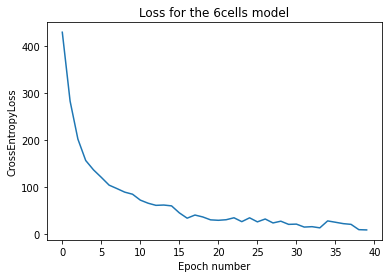

In [27]:
# Set the parameters
num_channels1 = 16
num_channels2 = 32
num_classes = 26
# Create the "6 cells" model
model = CNNSimple6Cells(num_channels1, num_channels2, num_classes)

# Optimizer
num_epochs = 40
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.003

# Training
model, loss_total = train_model(model, train_dataloader, val_dataloader, num_epochs, loss_fn, learning_rate, device='cpu', verbose=True, model_name="6cells", optim='Adam')

# Save the model and display the loss over epochs
torch.save(model.state_dict(), 'models/model_simple_6_cells.pt')

# Plot the results and save the figure
plt.plot(loss_total)
plt.title("Loss for the 6cells model")
plt.xlabel("Epoch number")
plt.ylabel("CrossEntropyLoss")
plt.savefig("plots/model_simple_6cells_loss.png") 
plt.show()

In [28]:
# Reloading the "6 cells" model
model = CNNSimple6Cells(num_channels1, num_channels2, num_classes)
# Load the parameters
model.load_state_dict(torch.load('models/model_6cells_best.pt'))
# Compute the accuracy
res = eval_model(model, test_dataloader, device='cpu')
print(res)

86.53846153846153


The results are here again very satisfying (around 86% accuracy)

In [29]:
# Fill dataframe with the results of this model
all_results["Model"].append("6cells")
all_results["Loss"].append("CrossEntropyLoss")
all_results["Optimizer"].append("Adam")
all_results["lr"].append(learning_rate)
all_results["Accuracy"].append(res)

# Third model

Our last model is also based on the fact that Braille is using 6 dots, but this time it maps the dot pattern to a letter, through a binary pattern.

In [30]:
# Create a map between letters and braille alphabet
# 1 is a black dot
# 0 is a white dot 
braille_map = {"a":"100000", "b":"110000", "c":"100100", "d":"100110", "e":"100010",
               "f":"110100", "g":"110110", "h":"110010", "i":"010100", "j":"101000",
               "k":"111000", "l":"101100", "m":"101110", "n":"101110", "o":"101010",
               "p":"111100", "q":"111110", "r":"111010", "s":"011100", "t":"011110",
               "u":"101001", "v":"111001", "w":"010111", "x":"101101", "y":"101111",
               "z":"101011"}

In [31]:
# Create the reverted map to go from dots to letters
braille_map_rev = {v:k for k, v in braille_map.items()}

In [32]:
# Define a CNN classifier module.

class CNNSimple6CellsMap(nn.Module):
    def __init__(self, num_channels1=16, num_channels2=32):
        """Models a classifier using the bit strings"""
        super(CNNSimple6CellsMap, self).__init__()
        
        # Create two sequential layers with convolution, ReLU, BatchNorm and Max Pooling
        self.l1 = nn.Sequential(nn.Conv2d(3, num_channels1, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(16),
                           nn.MaxPool2d(kernel_size=2))
        self.l2 = nn.Sequential(nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(32),
                           nn.MaxPool2d(kernel_size=2))
        
        size_vec = 1568
        
        # Create linear and sigmoid functions
        self.res = nn.Linear(size_vec, 6)
        self.finact = nn.Sigmoid()
        
    def forward(self, x):
        """Move from the input layers to the output layer"""
        x = self.l2(self.l1(x))
        x = x.reshape(x.shape[0], -1)
        out = self.finact(self.res(x))
        if self.training:
            return out
        else:
            res = []
            for t in out:
                key = "".join(map(lambda a: str(a.item()), torch.round(t).long()))
                if key not in braille_map_rev:
                    res.append(0)
                    continue
                res.append(dataset.letter_to_number(braille_map_rev[key]))
            res = nn.functional.one_hot(torch.tensor(res), num_classes=26)
            return res

## Experiments


New best accuracy!  50.0
Epoch [1/40], Loss: 64.0010
New best accuracy!  57.05128205128205
Epoch [3/40], Loss: 38.2522
New best accuracy!  57.69230769230769
Epoch [4/40], Loss: 32.3964
New best accuracy!  58.333333333333336
Epoch [5/40], Loss: 28.4894
New best accuracy!  63.46153846153846
Epoch [7/40], Loss: 21.6242
New best accuracy!  69.87179487179488
Epoch [8/40], Loss: 18.9555
New best accuracy!  71.7948717948718
Epoch [9/40], Loss: 16.7832
New best accuracy!  73.71794871794872
Epoch [10/40], Loss: 14.5653
New best accuracy!  76.92307692307692
Epoch [24/40], Loss: 2.76147
New best accuracy!  77.56410256410257
Epoch [40/40], Loss: 0.8887

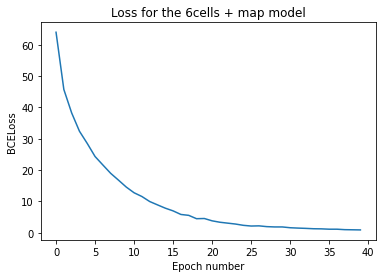

In [33]:
# Set the parameters
num_channels1 = 16
num_channels2 = 32
num_classes = 26
# Create the "6 cells + map" model
model = CNNSimple6CellsMap(num_channels1, num_channels2)

# Optimizer
num_epochs = 40
loss_fn = nn.BCELoss()
learning_rate = 0.01

# Training
model, loss_total = train_model(model, train_dataloader, val_dataloader, num_epochs, loss_fn, learning_rate, device='cpu', verbose=True, model_name="6cells_map", optim='SGD', cells=True)

# Save the model and display the loss over epochs
torch.save(model.state_dict(), 'models/model_6_cells_map.pt')

# Plot the results and save the figure
plt.title("Loss for the 6cells + map model")
plt.xlabel("Epoch number")
plt.ylabel("BCELoss")

plt.plot(loss_total)
plt.savefig("plots/model_simple_6cells_map_loss.png") 
plt.show()

In [34]:
# Reloading the "6 cells + map" model
model = CNNSimple6CellsMap(num_channels1, num_channels2)
# Load the parameters
model.load_state_dict(torch.load('models/model_6cells_map_best.pt'))
# Compute the accuracy
res = eval_model(model, test_dataloader, device='cpu')
print(res)

80.12820512820512


The accuracy is around 80%, which is in accordance with the two first models.

In [35]:
# Fill dataframe with the results of this model
all_results["Model"].append("6cells_map")
all_results["Loss"].append("BCELoss")
all_results["Optimizer"].append("SGD")
all_results["lr"].append(learning_rate)
all_results["Accuracy"].append(res)

We then put all our results in a dataframe:

In [36]:
df_results = pd.DataFrame(all_results)

And convert this dataframe to a csv file:

In [37]:
df_results.to_csv("evaluation_results.csv")

In [38]:
df_results

,Model,Loss,Optimizer,lr,Accuracy
0,simple,CrossEntropyLoss,SGD,0.001,79.487179
1,6cells,CrossEntropyLoss,Adam,0.003,86.538462
2,6cells_map,BCELoss,SGD,0.010,80.128205


We finally load this csv to display it:

In [39]:
pd.read_csv("evaluation_results.csv", index_col=0)

,Model,Loss,Optimizer,lr,Accuracy
0,simple,CrossEntropyLoss,SGD,0.001,79.487179
1,6cells,CrossEntropyLoss,Adam,0.003,86.538462
2,6cells_map,BCELoss,SGD,0.010,80.128205
